#Overview & motivation

All of our team members enjoy movies. In addition to enjoying movies, we also enjoy working with API’s and somewhat structured data sets. Therefore, determining what makes a movie successful using the data available in the Internet Movie Database (IMDB) and Wikipedia seemed like a natural choice.

In [1]:
from imdb import IMDb
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import cPickle as pickle
ia = IMDb(accessSystem='http')
from collections import defaultdict 
import io
from datetime import datetime
import time
import math
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

###Related Work

#Initial Questions

#Data

###Import Data

Because the goal of this aspect of our project is to attempt to predict Oscar winners from those nominated, we First we split our data into a test set (movies in 2006) and a training set (movies 1981-2005).  We will use k-fold cross validation to train our model.  In this preliminary analysis, we train our model to predict Oscar winners given the movie was nominated.

In [2]:
# Load AAdictfinal (dict of Oscar nominated movies) and convert to DataFrame
AAdf = pd.DataFrame.from_dict(pickle.load(open('AAdictfinal_copy.p','rb'))).transpose()

In [3]:
dftouse = AAdf.copy()
dftouse.reset_index(level=0, inplace=True)

In [4]:
cols_to_delete = ['title','won','mpaa','movieid', 'cast', 'director','index',
 u'Won Best Actor',
 u'Won Best Actress',
 u'Won Best Animated Feature Film',
 u'Won Best Art Direction',
 u'Won Best Cinematography',
 u'Won Best Costume Design',
 u'Won Best Director',
 u'Won Best Documentary, Feature',
 u'Won Best Documentary, Short Subject',
 u'Won Best Film Editing',
 u'Won Best Foreign Language Film',
 u'Won Best Makeup',
 u'Won Best Music, Adaptation / Original Song Score',
 u'Won Best Music, Dramatic Score',
 u'Won Best Music, Musical or Comedy Score',
 u'Won Best Music, Original Score',
 u'Won Best Music, Song',
 u'Won Best Picture',
 u'Won Best Short Film, Animated',
 u'Won Best Short Film, Live Action',
 u'Won Best Sound',
 u'Won Best Sound Editing',
 u'Won Best Sound Effects Editing',
 u'Won Best Sound Mixing',
 u'Won Best Supporting Actor',
 u'Won Best Supporting Actress',
 u'Won Best Visual Effects',
 u'Won Best Writing, Adapted Screenplay',
 u'Won Best Writing, Original Screenplay',
 u'Won Special Achievement Award']
for col in cols_to_delete:
    del dftouse[col]

In [5]:
list(dftouse.columns)

[u'Action',
 u'Adventure',
 u'Animation',
 u'Biography',
 u'Comedy',
 u'Crime',
 u'Documentary',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'France',
 u'Germany',
 u'History',
 u'Horror',
 u'Italy',
 u'Music',
 u'Musical',
 u'Mystery',
 u'News',
 u'Nominated Best Actor',
 u'Nominated Best Actress',
 u'Nominated Best Animated Feature Film',
 u'Nominated Best Art Direction',
 u'Nominated Best Cinematography',
 u'Nominated Best Costume Design',
 u'Nominated Best Director',
 u'Nominated Best Documentary, Feature',
 u'Nominated Best Documentary, Short Subject',
 u'Nominated Best Film Editing',
 u'Nominated Best Foreign Language Film',
 u'Nominated Best Makeup',
 u'Nominated Best Music, Adaptation / Original Song Score',
 u'Nominated Best Music, Dramatic Score',
 u'Nominated Best Music, Musical or Comedy Score',
 u'Nominated Best Music, Original Score',
 u'Nominated Best Music, Song',
 u'Nominated Best Picture',
 u'Nominated Best Short Film, Animated',
 u'Nominated Best Short Film, Live Action',


In [6]:
# Creat a list of indicator variables

NONINDICATORS = set(['month','mpaaint','numnominations','quarter','runtime'])
INDICATORS = set(list(dftouse.columns)) - set(NONINDICATORS)
INDICATORS.remove(u'winner')
INDICATORS.remove('year')

In [7]:
for indicatorcol in INDICATORS:
    # Check if not boolean
    if u'Nominated' in indicatorcol:
        dftouse[indicatorcol] = dftouse[indicatorcol].apply(lambda x: (type(x)==unicode or type(x)==str)*1)

###Exploratory Data Analysis


C:\Users\Steven\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
C:\Users\Steven\Anaconda\lib\site-packages\matplotlib\figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


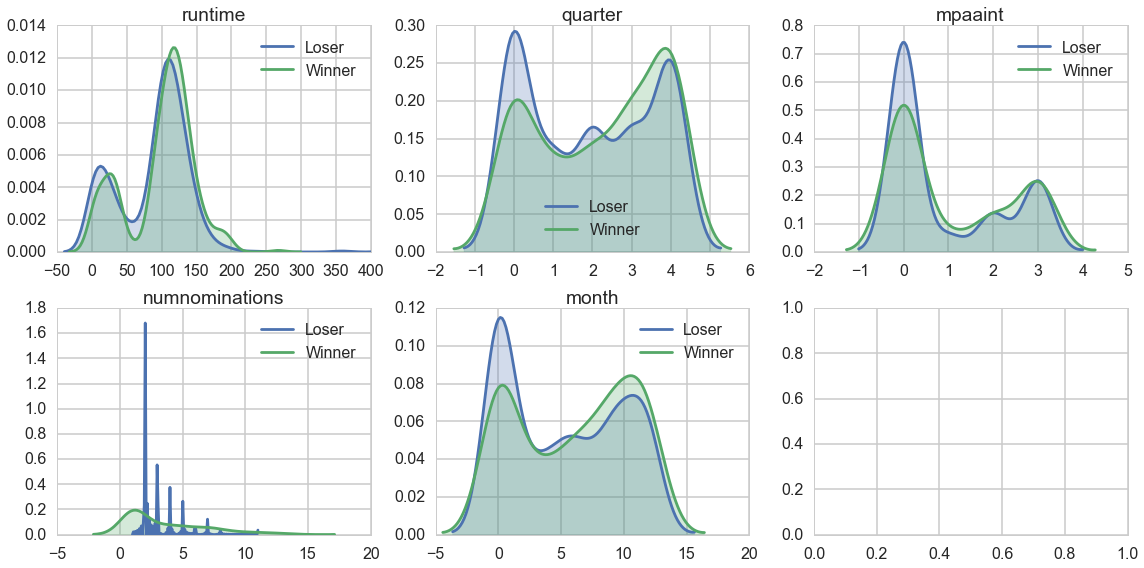

In [8]:
# Code Credit:  HW #3
dfgb=dftouse.groupby('winner')
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), NONINDICATORS):
    for k, v in dfgb[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner" 
        sns.kdeplot(v, ax=ax, label = label, shade = True)
        ax.set_title(p)

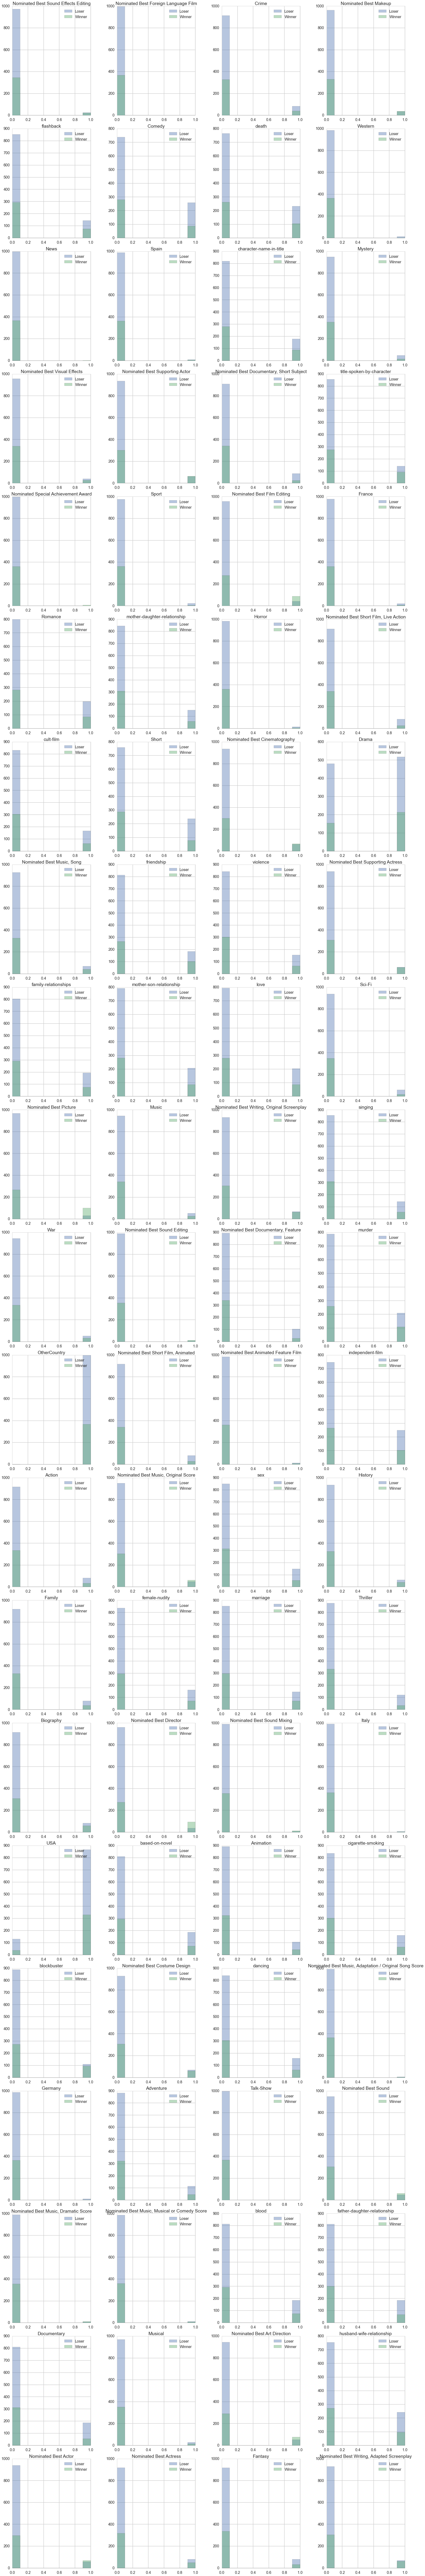

In [9]:
# Code Credit:  HW #3
fig, axes = plt.subplots(nrows=21, ncols=4, figsize=(25,150), 
                         tight_layout=True)
for ax, p in zip(axes.ravel(), INDICATORS):
    for k, v in dfgb[p]:
        if k == 0:
            label = "Loser"
        else:
            label = "Winner" 
        v.hist(ax=ax, alpha=0.4, label=label, range = [0,1])
        ax.set_title(p)
        ax.legend()

#Predicting Oscar Winners

In [10]:
## Split Data

# Test Set:  will be 2006 movies
itest = dftouse.index[dftouse['year']>=2006].copy()
testdf = dftouse[dftouse['year']>=2006].copy()
# Training Set:  1981-2005 movies
itrain = dftouse.index[dftouse['year']<2005].copy()
traindf = dftouse[dftouse['year']<2005].copy()

In [11]:
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
lcols = list(INDICATORS) + list(NONINDICATORS)

In [12]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, X, y, n_jobs, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, scoring=score_func, n_jobs=n_jobs)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_
    best = gs.best_estimator_
    return best

In [13]:
from sklearn.metrics import confusion_matrix
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, 
                score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask != None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=n_folds, n_jobs=n_jobs, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.3f" % (training_accuracy)
    print "Accuracy on test data:     %0.3f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

### Baseline Classifiers

In [14]:
# Baseline: all losers =
testsize = dftouse[~mask].shape[0]
ypred_nowins = np.zeros(testsize, dtype="int")
conf_nowins = confusion_matrix(list(testdf['winner']), ypred_nowins)
print conf_nowins
print "Accuracy on test data:", (float(conf_nowins[0,0]+conf_nowins[1,1])/testsize)

[[42  0]
 [16  0]]
Accuracy on test data: 0.724137931034


In [15]:
# Baseline: all winners = 
ypred_allwins = np.ones(testsize, dtype="int")
conf_allwins = confusion_matrix(list(testdf['winner']), ypred_allwins)
print conf_allwins
print "Accuracy on test data:", (float(conf_allwins[0,0]+conf_allwins[1,1])/testsize)

[[ 0 42]
 [ 0 16]]
Accuracy on test data: 0.275862068966


### Logistic Regression Techniques

#### Logistic Ridge Regression

In [16]:
from sklearn.linear_model import LogisticRegression

clflog_ridge, Xtrain, ytrain, Xtest, ytest = do_classify(LogisticRegression(penalty="l1"),
                                                   {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                                   indf=dftouse, featurenames=lcols, targetname='winner', 
                                                   target1val=1, mask=mask)

using mask
BEST {'C': 1.0} 0.795558958652
############# based on standard predict ################
Accuracy on training data: 0.811
Accuracy on test data:     0.810
[[41  1]
 [10  6]]
########################################################


C:\Users\Steven\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [17]:
reuse_split=dict(Xtrain=Xtrain, Xtest=Xtest, ytrain=ytrain, ytest=ytest)

#### Logistic Regression with LASSO

In [18]:
clflog_lasso, _, _, _, _ = do_classify(LogisticRegression(penalty="l2"),
                                       {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.1} 0.799387442573
############# based on standard predict ################
Accuracy on training data: 0.810
Accuracy on test data:     0.828
[[42  0]
 [10  6]]
########################################################


#### Elastic Net Regularized Logistic Regression

In [19]:
from sklearn.linear_model import SGDClassifier

clflog_elastic, _, _, _, _ = do_classify(SGDClassifier(loss="log",penalty="elasticnet"), 
                                         {"alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                                          "l1_ratio": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
                                         indf=dftouse, featurenames=lcols, targetname='winner', 
                                         target1val=1, reuse_split=reuse_split)

using reuse split
BEST {'alpha': 0.1, 'l1_ratio': 0.2} 0.763399693721
############# based on standard predict ################
Accuracy on training data: 0.704
Accuracy on test data:     0.707
[[32 10]
 [ 7  9]]
########################################################


In [20]:
import sklearn.metrics as metrics

def t_repredict_accuracy(clf,t, xtest, ytest):
    probs=clf.predict_proba(xtest)
    p0 = probs[:,0]
    p1 = probs[:,1]
    ypred = (p1 > t)*1
    return metrics.accuracy_score(ytest, ypred)

In [22]:
for percent in np.arange(0.30,0.60,0.05):
    print "RidgeReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_ridge,percent,Xtest,ytest)
print ""
for percent in np.arange(0.30,0.60,0.05):
    print "LassoReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_lasso,percent,Xtest,ytest)
print ""
for percent in np.arange(0.30,0.60,0.05):
    print "ElasticReg Accuracy at",percent,"%: ",t_repredict_accuracy(clflog_elastic,percent,Xtest,ytest)

RidgeReg Accuracy at 0.3 %:  0.810344827586
RidgeReg Accuracy at 0.35 %:  0.827586206897
RidgeReg Accuracy at 0.4 %:  0.810344827586
RidgeReg Accuracy at 0.45 %:  0.810344827586
RidgeReg Accuracy at 0.5 %:  0.810344827586
RidgeReg Accuracy at 0.55 %:  0.827586206897

LassoReg Accuracy at 0.3 %:  0.862068965517
LassoReg Accuracy at 0.35 %:  0.844827586207
LassoReg Accuracy at 0.4 %:  0.827586206897
LassoReg Accuracy at 0.45 %:  0.844827586207
LassoReg Accuracy at 0.5 %:  0.827586206897
LassoReg Accuracy at 0.55 %:  0.810344827586

ElasticReg Accuracy at 0.3 %:  0.275862068966
ElasticReg Accuracy at 0.35 %:  0.293103448276
ElasticReg Accuracy at 0.4 %:  0.396551724138
ElasticReg Accuracy at 0.45 %:  0.603448275862
ElasticReg Accuracy at 0.5 %:  0.706896551724
ElasticReg Accuracy at 0.55 %:  0.706896551724


## SVM Techniques

#### Balance Features

In [23]:
jtrain=np.arange(0, ytrain.shape[0])
n_pos=len(jtrain[ytrain==1])
n_neg=len(jtrain[ytrain==0])
print n_pos, n_neg

351 955


In [24]:
ineg = np.random.choice(jtrain[ytrain==0], n_pos, replace=False)
alli=np.concatenate((jtrain[ytrain==1], ineg))

Xtrain_new = Xtrain[alli]
ytrain_new = ytrain[alli]
Xtrain_new.shape, ytrain_new.shape

((702L, 90L), (702L,))

In [25]:
reuse_split_new=dict(Xtrain=Xtrain_new, Xtest=Xtest, ytrain=ytrain_new, ytest=ytest)

#### SVM (Linear Kernel) - All Features Balanced

In [26]:
from sklearn.svm import LinearSVC

clf_linsvm, _, _, _, _ = do_classify(LinearSVC(loss="hinge"), {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split)

using reuse split
BEST {'C': 0.01} 0.791730474732
############# based on standard predict ################
Accuracy on training data: 0.799
Accuracy on test data:     0.810
[[42  0]
 [11  5]]
########################################################


#### SVM (RBF Kernel) - All Features Balanced

In [27]:
from sklearn.svm import SVC

clf_rbfsvm, _, _, _, _ = do_classify(SVC(kernel="rbf"),
                                       {"C": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split)

using reuse split
BEST {'C': 1.0} 0.786370597243
############# based on standard predict ################
Accuracy on training data: 0.815
Accuracy on test data:     0.793
[[41  1]
 [11  5]]
########################################################


##### Random Forest Classifier

Because the RandomForest Classifier can't take categorical variables as inputs.  Therefore we have to deal with the categorical variables in some way.

For categorical variables that are considered ordinal (mpaa), we can just convert them to ints.
For categorical varaibles that are not ordinal (keywords), we will use sparse matrcies.

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_randomforest, _, _, _, _ = do_classify(RandomForestClassifier(n_estimators=10000, random_state=0),
                                       {"max_depth": [5,10,15,20,25],"min_samples_split":[5,10,15,20,25]}, 
                                       indf=dftouse, featurenames=lcols, targetname='winner', 
                                       target1val=1, reuse_split=reuse_split, n_jobs=5)

In [100]:
# Roc curve function, taken from HW3
from sklearn.metrics import roc_curve, auc
def make_roc(name, clf, ytest, xtest, ax=None, labe=5, proba=True, skip=0):
    initial=False
    if not ax:
        ax=plt.gca()
        initial=True
    if proba:#for stuff like logistic regression
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:#for stuff like SVM
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', alpha=0.3, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    if labe!=None:
        for k in xrange(0, fpr.shape[0],labe):
            #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
            threshold = str(np.round(thresholds[k], 2))
            ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

### Model Setup

### Cross Validation

#Exploratory Data Analysis

#Final Analysis

#Presentation